In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/bengaliai-cv19/test_image_data_2.parquet
/kaggle/input/bengaliai-cv19/test_image_data_3.parquet
/kaggle/input/bengaliai-cv19/test_image_data_0.parquet
/kaggle/input/bengaliai-cv19/train.csv
/kaggle/input/bengaliai-cv19/test_image_data_1.parquet
/kaggle/input/bengaliai-cv19/class_map.csv
/kaggle/input/bengaliai-cv19/train_image_data_3.parquet
/kaggle/input/bengaliai-cv19/train_image_data_2.parquet
/kaggle/input/bengaliai-cv19/test.csv
/kaggle/input/bengaliai-cv19/sample_submission.csv
/kaggle/input/bengaliai-cv19/train_image_data_1.parquet
/kaggle/input/bengaliai-cv19/train_image_data_0.parquet


# Resizing function

Resizing function taken from [this notebook](https://www.kaggle.com/maxlenormand/cropping-to-character-resizing-images) from Maxime Lenormand

In [2]:
HEIGHT = 137
WIDTH = 236
CROP_SIZE = 80

In [3]:
def crop_and_resize_images(df, pad, resized_df, resize_size = CROP_SIZE):
    cropped_imgs = {}
    for img_id in tqdm(range(df.shape[0])):
        img = resized_df[img_id]
        _, thresh = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
        
        idx = 0 
        ls_xmin = []
        ls_ymin = []
        ls_xmax = []
        ls_ymax = []
        
        # Dectection of character boundaries
        for cnt in contours:
            idx += 1
            x,y,w,h = cv2.boundingRect(cnt)
            ls_xmin.append(x)
            ls_ymin.append(y)
            ls_xmax.append(x + w)
            ls_ymax.append(y + h)
            
        # Cropping of image to character boundaries
        xmin = max(min(ls_xmin)-pad,0)
        ymin = max(min(ls_ymin)-pad,0)
        xmax = min(max(ls_xmax)+pad, WIDTH)
        ymax = min(max(ls_ymax)+pad, HEIGHT)
        
        # Resizing image to cropping size
        roi = img[ymin:ymax,xmin:xmax]
        resized_roi = cv2.resize(roi, (resize_size, resize_size))
        cropped_imgs[df.image_id[img_id]] = resized_roi.reshape(-1)
    
    resized = pd.DataFrame(cropped_imgs).T.reset_index()
    resized.columns = resized.columns.astype(str)
    resized.rename(columns={'index':'image_id'},inplace=True)
    return resized #out_df

100%|██████████| 50210/50210 [00:54<00:00, 923.71it/s]


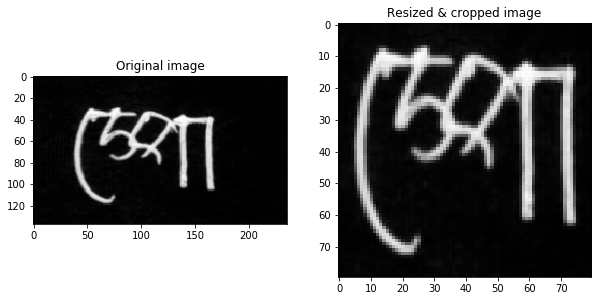

100%|██████████| 50210/50210 [00:48<00:00, 1034.85it/s]


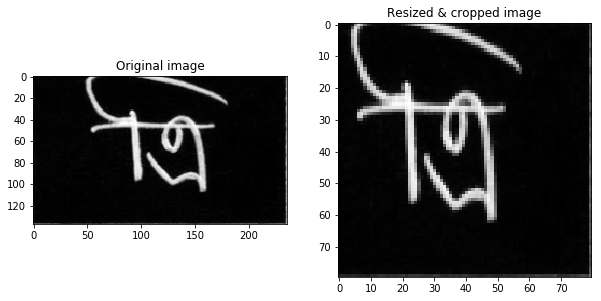

100%|██████████| 50210/50210 [00:52<00:00, 953.07it/s]


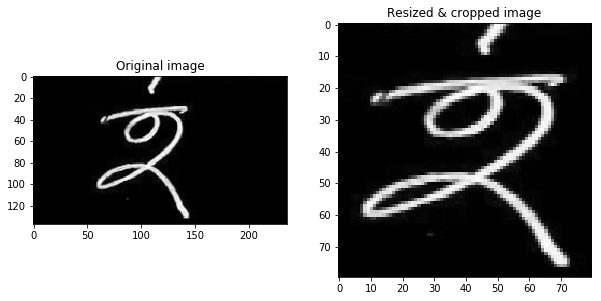

100%|██████████| 50210/50210 [00:54<00:00, 927.72it/s]


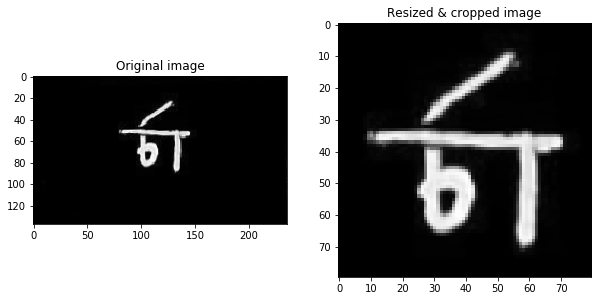

In [4]:
for i in range(4):
    # Loading dataset
    train_df = pd.read_parquet(f'/kaggle/input/bengaliai-cv19/train_image_data_{i}.parquet')
    
    # Reshaping to array (HEIGHT x WIDTH)
    resized = train_df.iloc[:, 1:32333].values.reshape(-1, HEIGHT, WIDTH)
    
    # Cropping and resizing
    cropped_df = crop_and_resize_images(train_df, 10, resized, CROP_SIZE)
    
    # Save as feather format
    cropped_df.to_feather(f'train_data_{i}.feather')
    
    # Reshaping as array (CROP_SIZE x CROP_SIZE)
    resized_sample = cropped_df.iloc[:, 1:].values.reshape(-1, CROP_SIZE, CROP_SIZE)
    
    # Plotting one image of set in original format and resized format
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 15))
    ax0.imshow(resized[5], cmap='Greys')
    ax0.set_title('Original image')
    ax1.imshow(resized_sample[5], cmap='Greys')
    ax1.set_title('Resized & cropped image')
    plt.show()

    del train_df
    del resized
    del cropped_df